## Linear Discriminant Analysis

```
https://sebastianraschka.com/Articles/2014_python_lda.html
```
#### Filename: LDA-v1.ipynb
##### Version Log:
```
v1: 28-Jun-2018: Copy from the WebPage; Note one line of code was not working and needed correction:
# X = df[[0,1,2,3]].values
X = df.drop('class label',axis=1).as_matrix(columns=None)
```

### Preparing the sample data set

In [1]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

In [2]:
feature_dict

{0: 'sepal length in cm',
 1: 'sepal width in cm',
 2: 'petal length in cm',
 3: 'petal width in cm'}

### Reading in the dataset

In [3]:
import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()

sepal length in cm  sepal width in cm  petal length in cm  \
145                 6.7                3.0                 5.2   
146                 6.3                2.5                 5.0   
147                 6.5                3.0                 5.2   
148                 6.2                3.4                 5.4   
149                 5.9                3.0                 5.1   

     petal width in cm     class label  
145                2.3  Iris-virginica  
146                1.9  Iris-virginica  
147                2.0  Iris-virginica  
148                2.3  Iris-virginica  
149                1.8  Iris-virginica

In [4]:
df.columns

Index(['sepal length in cm', 'sepal width in cm', 'petal length in cm',
       'petal width in cm', 'class label'],
      dtype='object')

```
Since it is more convenient to work with numerical values, we will use the LabelEncode from the scikit-learn library to convert the class labels into numbers: 1, 2, and 3.
```

In [5]:
from sklearn.preprocessing import LabelEncoder

# X = df[[0,1,2,3]].values
# X = df.columns[[0,1,2,3]].values
# X = df.drop('class label',axis=1)
# X and y should be numpy arrays
X = df.drop('class label',axis=1).as_matrix(columns=None)
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

In [6]:
type(X)

numpy.ndarray

### Histograms and feature selection
```
Just to get a rough idea how the samples of our three classes ω1, ω2 and ω3 are distributed, let us visualize the distributions of the four different features in 1-dimensional histograms.
```

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math

C:\Users\USWU32441\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


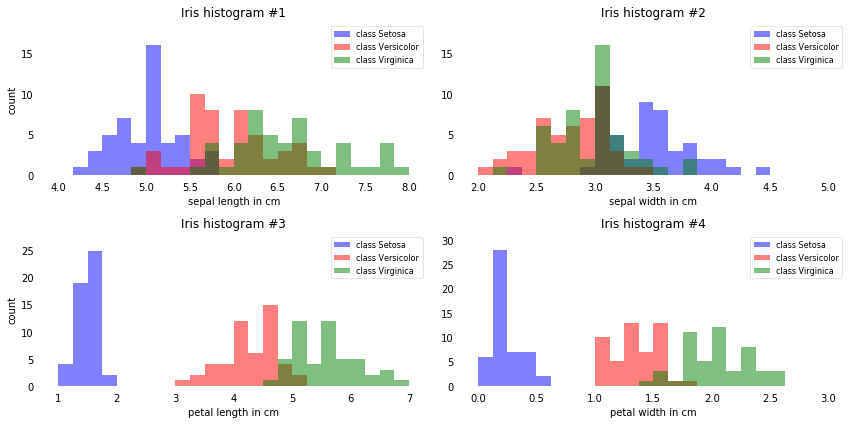

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

### LDA in 5 steps
```
After we went through several preparation steps, our data is finally ready for the actual LDA. In practice, LDA for dimensionality reduction would be just another preprocessing step for a typical machine learning or pattern classification task.

Step 1: Computing the d-dimensional mean vectors

In this first step, we will start off with a simple computation of the mean vectors mmi
, (i=1,2,3) of the 3 different flower classes:
```

In [9]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



### Step 2: Computing the Scatter Matrices
```
Now, we will compute the two 4x4-dimensional matrices: The within-class and the between-class scatter matrix.
2.1 Within-class scatter matrix SW
```

In [10]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


### 2.1 b
### 2.2 Between-class scatter matrix SB

In [11]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


In [12]:
S_W.shape

(4, 4)

In [13]:
S_B.shape

(4, 4)

### Step 3: Solving the generalized eigenvalue problem for the matrix S−1WSB

In [14]:
np.linalg.inv(S_W).dot(S_B)

array([[ -3.0247,   1.0485,  -8.0187,  -3.4249],
       [ -5.6209,   2.1525, -15.1084,  -6.3827],
       [  8.029 ,  -2.8654,  21.3687,   9.0984],
       [ 10.6672,  -3.4133,  27.9905,  12.0531]])

In [15]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.8379]
 [ 0.1696]
 [ 0.1229]
 [ 0.5041]]
Eigenvalue 3: -4.13e-15

Eigenvector 4: 
[[ 0.2   ]
 [-0.3949]
 [-0.4567]
 [ 0.7717]]
Eigenvalue 4: 1.20e-14


In [16]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


### Step 4: Selecting linear discriminants for the new feature subspace

In [17]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.27195779972981
0.27756686384004264
1.1953730364935478e-14
4.1311796919088535e-15


In [18]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [19]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


### Step 5: Transforming the samples onto the new subspace

In [20]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

C:\Users\USWU32441\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


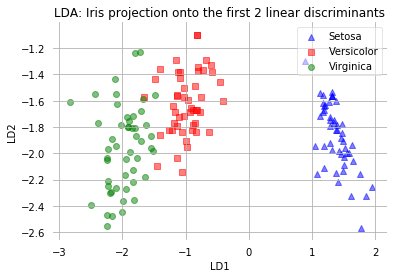

In [21]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

### A comparison of PCA and LDA

In [22]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()

    plt.show()

C:\Users\USWU32441\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


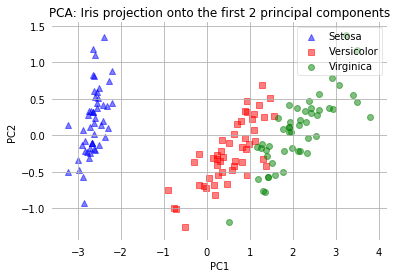

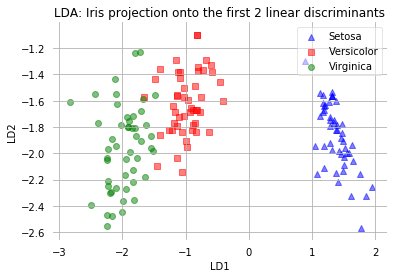

In [23]:
plot_pca()
plot_step_lda()

### LDA via scikit-learn

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)
print(X.shape)
print(y.shape)
print(X_lda_sklearn.shape)

(150, 4)
(150,)
(150, 2)


In [25]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

C:\Users\USWU32441\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


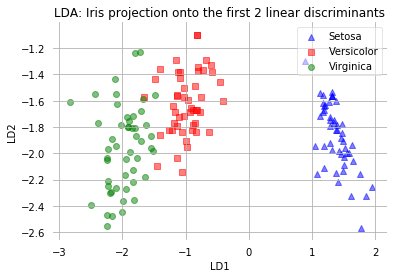

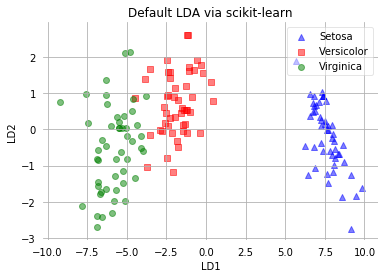

In [26]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')

## A Note About Standardization

In [27]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df[4] = df[4].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
df.tail()

0    1    2    3  4
145  6.7  3.0  5.2  2.3  2
146  6.3  2.5  5.0  1.9  2
147  6.5  3.0  5.2  2.0  2
148  6.2  3.4  5.4  2.3  2
149  5.9  3.0  5.1  1.8  2

In [28]:
y, X = df.iloc[:, 4].values, df.iloc[:, 0:4].values
X_cent = X - X.mean(axis=0)
X_std = X_cent / X.std(axis=0)

```
Below, I simply copied the individual steps of an LDA, which we discussed previously, into Python functions for convenience.
```

In [29]:
import numpy as np

def comp_mean_vectors(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    mean_vectors = []
    for cl in class_labels:
        mean_vectors.append(np.mean(X[y==cl], axis=0))
    return mean_vectors

def scatter_within(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)
    S_W = np.zeros((n_features, n_features))
    for cl, mv in zip(class_labels, mean_vectors):
        class_sc_mat = np.zeros((n_features, n_features))                 
        for row in X[y == cl]:
            row, mv = row.reshape(n_features, 1), mv.reshape(n_features, 1)
            class_sc_mat += (row-mv).dot((row-mv).T)
        S_W += class_sc_mat                           
    return S_W

def scatter_between(X, y):
    overall_mean = np.mean(X, axis=0)
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)    
    S_B = np.zeros((n_features, n_features))
    for i, mean_vec in enumerate(mean_vectors):  
        n = X[y==i+1,:].shape[0]
        mean_vec = mean_vec.reshape(n_features, 1)
        overall_mean = overall_mean.reshape(n_features, 1)
        S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    return S_B

def get_components(eig_vals, eig_vecs, n_comp=2):
    n_features = X.shape[1]
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    W = np.hstack([eig_pairs[i][1].reshape(4, 1) for i in range(0, n_comp)])
    return W

```
First, we are going to print the eigenvalues, eigenvectors, transformation matrix of the un-scaled data:
```

In [30]:
S_W, S_B = scatter_within(X, y), scatter_between(X, y)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
W = get_components(eig_vals, eig_vecs, n_comp=2)
print('EigVals: %s\n\nEigVecs: %s' % (eig_vals, eig_vecs))
print('\nW: %s' % W)

EigVals: [ 2.0905e+01+0.000e+00j  1.4283e-01+0.000e+00j -6.9935e-16+8.447e-16j
 -6.9935e-16-8.447e-16j]

EigVecs: [[ 0.2067+0.j      0.0018+0.j     -0.281 +0.1937j -0.281 -0.1937j]
 [ 0.4159+0.j     -0.5626+0.j     -0.2173-0.0855j -0.2173+0.0855j]
 [-0.5616+0.j      0.2232+0.j     -0.2894-0.0843j -0.2894+0.0843j]
 [-0.6848+0.j     -0.796 +0.j      0.8592+0.j      0.8592-0.j    ]]

W: [[ 0.2067+0.j  0.0018+0.j]
 [ 0.4159+0.j -0.5626+0.j]
 [-0.5616+0.j  0.2232+0.j]
 [-0.6848+0.j -0.796 +0.j]]


C:\Users\USWU32441\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


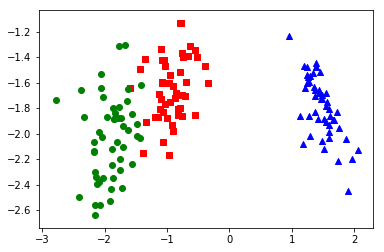

In [31]:
X_lda = X.dot(W)
for label,marker,color in zip(
        np.unique(y),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(X_lda[y==label, 0], X_lda[y==label, 1],
                color=color, marker=marker)

```
Next, we are repeating this process for the standarized flower dataset:
```

In [32]:
S_W, S_B = scatter_within(X_std, y), scatter_between(X_std, y)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
W_std = get_components(eig_vals, eig_vecs, n_comp=2)
print('EigVals: %s\n\nEigVecs: %s' % (eig_vals, eig_vecs))
print('\nW: %s' % W_std)

EigVals: [ 2.0905e+01  1.4283e-01 -5.0076e-16  2.0494e-16]

EigVecs: [[-0.1492 -0.0019  0.7292 -0.7426]
 [-0.1572  0.3193 -0.1661  0.021 ]
 [ 0.8635 -0.5155 -0.6637 -0.0511]
 [ 0.4554  0.7952 -0.0109  0.6675]]

W: [[-0.1492 -0.0019]
 [-0.1572  0.3193]
 [ 0.8635 -0.5155]
 [ 0.4554  0.7952]]


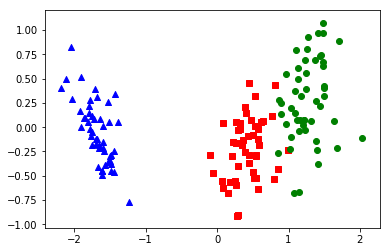

In [33]:
X_std_lda = X_std.dot(W_std)
X_std_lda[:, 1] = X_std_lda[:, 1]
for label,marker,color in zip(
        np.unique(y),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(X_std_lda[y==label, 0], X_std_lda[y==label, 1],
                color=color, marker=marker)

```
As we can see, the eigenvalues are excactly the same whether we scaled our data or not (note that since W

has a rank of 2, the two lowest eigenvalues in this 4-dimensional dataset should effectively be 0). Furthermore, we see that the projections look identical except for the different scaling of the component axes and that it is mirrored in this case.
Have feedback on this post? I would love to hear it. Let me know and send me a tweet or email.
```